In [1]:
import pandas as pd
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from lib import helper
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


# training data
train_x = pd.read_csv('train.zip')
train_y = pd.read_csv('train_labels.zip')


ValueError: cannot reshape array of size 441197568 into shape (2931,331,331,3)

In [3]:
image_size = 224
x_train = np.array(train_x)[:,1:].reshape((train_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y = np.array(train_y.iloc[:,1])

# validation data
val_x = pd.read_csv('val.zip')
val_y = pd.read_csv('val_labels.zip')


x_val = np.array(val_x)[:,1:].reshape((val_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y_val = np.array(val_y.iloc[:,1])


num_class = max(y) + 1

In [4]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [5]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), labels[indexes]

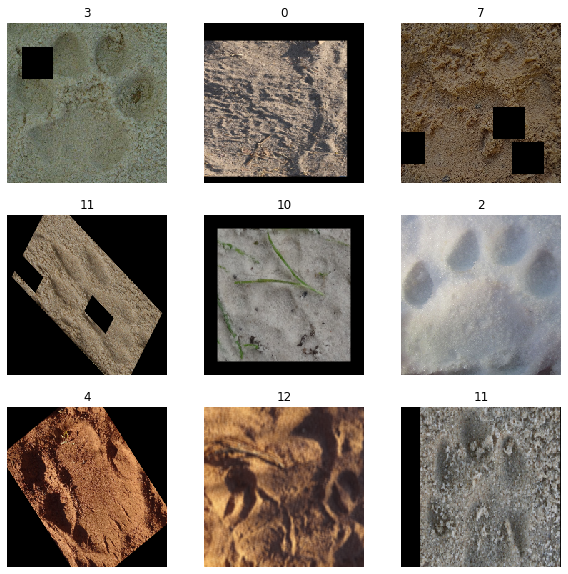

In [6]:
images = generator(x_train,y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(image[1][i])
    plt.axis("off")

In [7]:
image_size = 299
base_model = keras.applications.InceptionResNetV2(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

219062272/219055592 [==============================] - 1s 0us/step


In [8]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_class)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 13)                19981     
Total params: 54,356,717
Trainable params: 54,296,173
Non-trainable params: 60,544
_________________________________________________________________


In [9]:
# Model optimizer
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
46/45 [==============================] - 41s 885ms/step - loss: 74.4076 - accuracy: 0.0802 - val_loss: 30.6165 - val_accuracy: 0.0167 - lr: 5.0000e-04
Epoch 2/100
46/45 [==============================] - 35s 768ms/step - loss: 19.3528 - accuracy: 0.0849 - val_loss: 20.0637 - val_accuracy: 0.0861 - lr: 5.0000e-04
Epoch 3/100
46/45 [==============================] - 36s 772ms/step - loss: 20.3996 - accuracy: 0.1009 - val_loss: 26.6186 - val_accuracy: 0.1083 - lr: 5.0000e-04
Epoch 4/100
46/45 [==============================] - 35s 770ms/step - loss: 17.5152 - accuracy: 0.1158 - val_loss: 17.8428 - val_accuracy: 0.0806 - lr: 5.0000e-04
Epoch 5/100
46/45 [==============================] - 36s 781ms/step - loss: 20.4719 - accuracy: 0.1162 - val_loss: 25.1906 - val_accuracy: 0.1528 - lr: 5.0000e-04
Epoch 6/100
46/45 [==============================] - 36s 775ms/step - loss: 19.7809 - accuracy: 0.1274 - val_loss: 19.7753 - val_accuracy: 0.0722 - lr: 5.0000e-04
Epoch 7/100
46/45 [===

In [10]:
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 32
# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/200
92/91 [==============================] - 125s 1s/step - loss: 6.2272 - accuracy: 0.1019 - val_loss: 2.5037 - val_accuracy: 0.1528 - lr: 1.0000e-04
Epoch 2/200
92/91 [==============================] - 121s 1s/step - loss: 2.4292 - accuracy: 0.1427 - val_loss: 2.4511 - val_accuracy: 0.1611 - lr: 1.0000e-04
Epoch 3/200
92/91 [==============================] - 121s 1s/step - loss: 2.3739 - accuracy: 0.1590 - val_loss: 2.4518 - val_accuracy: 0.1333 - lr: 1.0000e-04
Epoch 4/200
92/91 [==============================] - 122s 1s/step - loss: 2.2340 - accuracy: 0.2171 - val_loss: 2.1236 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 5/200
92/91 [==============================] - 121s 1s/step - loss: 1.9983 - accuracy: 0.3308 - val_loss: 1.7598 - val_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 6/200
92/91 [==============================] - 122s 1s/step - loss: 1.6538 - accuracy: 0.4562 - val_loss: 1.4552 - val_accuracy: 0.5278 - lr: 1.0000e-04
Epoch 7/200
92/91 [===========================

In [11]:
model.save('InceptionResNetV2.h5')

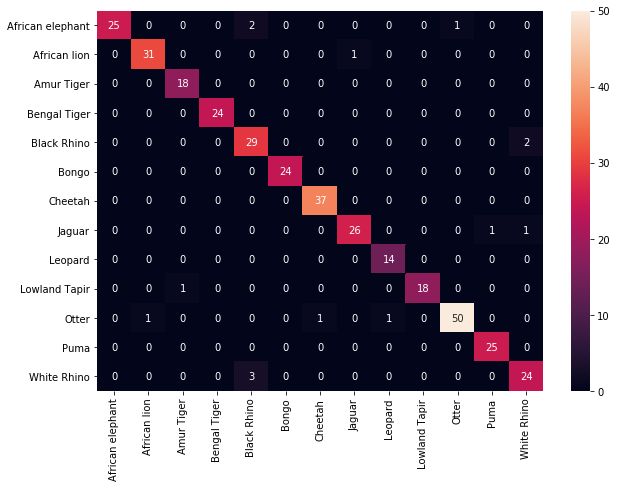

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['African elephant','African lion','Amur Tiger','Bengal Tiger', 'Black Rhino','Bongo' 
          ,'Cheetah','Jaguar','Leopard','Lowland Tapir', 'Otter','Puma','White Rhino']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [17]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("InceptionResNetV2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('InceptionResNetV2.tflite', 'wb') as f:
    f.write(tflite_model)

In [49]:
for i in range(5):
    index = np.random.randint(2390)
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y[index])

    interpreter = tf.lite.Interpreter(model_path="InceptionResNetV2.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (299,299)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result2039====
[[ 8.329775    9.2781515  -6.616677    1.3610272   0.228928   -5.3604536
  -3.934691    7.8704886   3.407471   -0.09927348 23.132019    4.494958
  -2.0975418 ]]
10
====TFLite result====
[[ 3.5870628   7.8632803  -3.3958733   0.24929924 -0.28832027 -4.517113
  -0.25846645  6.780815    1.5215472  -0.3445454  16.460524    3.9094965
  -2.9181762 ]]
10
====TF Model result66====
[[-2.659813    3.195975   -4.700597    6.8095584   1.7405972  24.425665
   8.734784   -2.8948507   4.4056334  -0.69356227 -7.1187973   9.461396
   1.2145058 ]]
5
====TFLite result====
[[-2.3883789  -1.1383936  -1.655189    6.088379    0.05215206  8.3238
   5.5213513   2.9551673   3.5795772  -1.6559896  -4.111552    7.5958066
   3.0846462 ]]
5
====TF Model result1239====
[[ 9.700891   -0.8781422  -8.340824   -9.830415   37.523376    0.5788122
  -2.898225    2.4215918   7.4806495  12.682601    0.17151162 -3.4455094
  12.575679  ]]
4
====TFLite result====
[[ 4.923331   -0.21947886 -1.8439144 